ref_dirs.shape: (2024, 4)


<IPython.core.display.Javascript object>


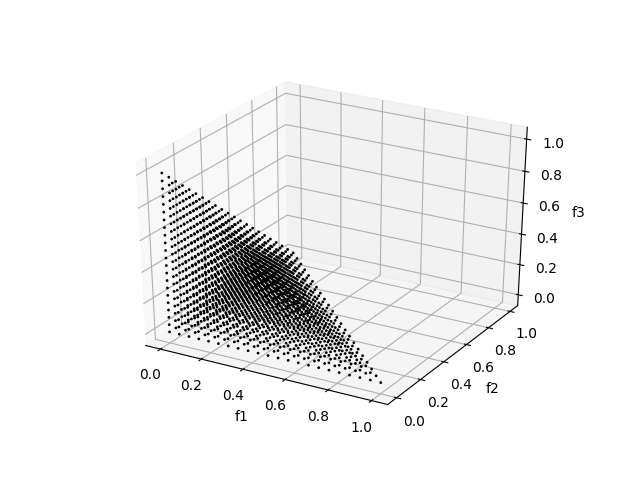

In [17]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import math

sys.path.append('../')
sys.path.append('../paretoviz')

import matplotlib.pyplot as plt
import autograd.numpy as anp

from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import nsga2
from pymoo.algorithms.nsga3 import nsga3
from pymoo.util import plotting
from pymop.factory import get_problem
from pymop.problem import Problem
from pymoo.util.reference_direction import MultiLayerReferenceDirectionFactory
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util import plotting

from paretoviz import plotting as pplt

class osy_nd(Problem):
    def __init__(self, n_obj = 2, n_constr = 6):
        self.n_obj = n_obj
        self.n_constr = n_constr
        super().__init__(n_var = 6, n_obj = self.n_obj, n_constr = self.n_constr, \
                         type_var = anp.double)
        self.xl = anp.array([0.0, 0.0, 1.0, 0.0, 1.0, 0.0])
        self.xu = anp.array([10.0, 10.0, 5.0, 6.0, 5.0, 10.0])

    def _evaluate(self, x, out, *args, **kwargs):
        f = [0] * 8
        g = [0] * 6
        f[0] = - (25 * anp.square(x[:, 0] - 2) + anp.square(x[:, 1] - 2) \
                + anp.square(x[:, 2] - 1) + anp.square(x[:, 3] - 4) \
                + anp.square(x[:, 4] - 1))
        f[1] = anp.sum(anp.square(x), axis = 1)
        f[2] = (x[:, 0] + x[:, 1] - 2.0) / 2.0
        f[3] = (6.0 - x[:, 0] - x[:, 1]) / 6.0
        f[4] = (2.0 - x[:, 1] + x[:, 0]) / 2.0
        f[5] = (2.0 - x[:, 0] + 3.0 * x[:, 1]) / 2.0
        f[6] = (4.0 - anp.square(x[:, 2] - 3.0) - x[:, 3]) / 4.0
        f[7] = (anp.square(x[:, 4] - 3.0) + x[:, 5] - 4.0) / 4.0
        
        g[0] = f[2]
        g[1] = f[3]
        g[2] = f[4]
        g[3] = f[5]
        g[4] = f[6]
        g[5] = f[7]

        out["F"] = anp.column_stack(f[0:self.n_obj])
        out["G"] = - anp.column_stack(g[0:self.n_constr])

# algo parameters
n_dim = 4
npop = 2000 if n_dim <= 3 else 2050
ref_dirs = UniformReferenceDirectionFactory(n_dim, n_points = npop).do()
# ref_dirs = MultiLayerReferenceDirectionFactory([\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 10, scaling = 1.0),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 10, scaling = 0.9),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 9, scaling = 0.8),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 7, scaling = 0.7),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 6, scaling = 0.6),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 5, scaling = 0.5),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 4, scaling = 0.4),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 3, scaling = 0.3),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 2, scaling = 0.2),\
#     UniformReferenceDirectionFactory(n_dim, n_partitions = 1, scaling = 0.1),\
# ]).do()

print("ref_dirs.shape:", ref_dirs.shape)

# Just plot the ref_dirs to see how do they look like.

# rd = ref_dirs.tolist()
# print(rd[0:10])

# do the scatter plot
(fig, ax) = pplt.scatter(ref_dirs.tolist())
# save the scatter plot
# scatterfpath = os.path.join(".", prefix + "-scatter.pdf")
# plt.savefig(scatterfpath, transparent = False)

plt.show()

Running nsga3
n_gen | n_eval  | cv (min/avg) 
1     | 2050    | 0.00000 / 1.66523
2     | 4100    | 0.00000 / 0.61332
3     | 6150    | 0.00000 / 0.18375
4     | 8200    | 0.00000 / 0.00938
5     | 10250   | 0.00000 / 0.00000
6     | 12300   | 0.00000 / 0.00000
7     | 14350   | 0.00000 / 0.00000
8     | 16400   | 0.00000 / 0.00000
9     | 18450   | 0.00000 / 0.00000
10    | 20500   | 0.00000 / 0.00000
11    | 22550   | 0.00000 / 0.00000
12    | 24600   | 0.00000 / 0.00000
13    | 26650   | 0.00000 / 0.00000
14    | 28700   | 0.00000 / 0.00000
15    | 30750   | 0.00000 / 0.00000
16    | 32800   | 0.00000 / 0.00000
17    | 34850   | 0.00000 / 0.00000
18    | 36900   | 0.00000 / 0.00000
19    | 38950   | 0.00000 / 0.00000
20    | 41000   | 0.00000 / 0.00000
21    | 43050   | 0.00000 / 0.00000
22    | 45100   | 0.00000 / 0.00000
23    | 47150   | 0.00000 / 0.00000
24    | 49200   | 0.00000 / 0.00000
25    | 51250   | 0.00000 / 0.00000
26    | 53300   | 0.00000 / 0.00000
27    | 55350   | 

225   | 461250  | 0.00000 / 0.00000
226   | 463300  | 0.00000 / 0.00000
227   | 465350  | 0.00000 / 0.00000
228   | 467400  | 0.00000 / 0.00000
229   | 469450  | 0.00000 / 0.00000
230   | 471500  | 0.00000 / 0.00000
231   | 473550  | 0.00000 / 0.00000
232   | 475600  | 0.00000 / 0.00000
233   | 477650  | 0.00000 / 0.00000
234   | 479700  | 0.00000 / 0.00000
235   | 481750  | 0.00000 / 0.00000
236   | 483800  | 0.00000 / 0.00000
237   | 485850  | 0.00000 / 0.00000
238   | 487900  | 0.00000 / 0.00000
239   | 489950  | 0.00000 / 0.00000
240   | 492000  | 0.00000 / 0.00000
241   | 494050  | 0.00000 / 0.00000
242   | 496100  | 0.00000 / 0.00000
243   | 498150  | 0.00000 / 0.00000
244   | 500200  | 0.00000 / 0.00000
245   | 502250  | 0.00000 / 0.00000
246   | 504300  | 0.00000 / 0.00000
247   | 506350  | 0.00000 / 0.00000
248   | 508400  | 0.00000 / 0.00000
249   | 510450  | 0.00000 / 0.00000
250   | 512500  | 0.00000 / 0.00000
251   | 514550  | 0.00000 / 0.00000
252   | 516600  | 0.00000 / 

453   | 928650  | 0.00000 / 0.00000
454   | 930700  | 0.00000 / 0.00000
455   | 932750  | 0.00000 / 0.00000
456   | 934800  | 0.00000 / 0.00000
457   | 936850  | 0.00000 / 0.00000
458   | 938900  | 0.00000 / 0.00000
459   | 940950  | 0.00000 / 0.00000
460   | 943000  | 0.00000 / 0.00000
461   | 945050  | 0.00000 / 0.00000
462   | 947100  | 0.00000 / 0.00000
463   | 949150  | 0.00000 / 0.00000
464   | 951200  | 0.00000 / 0.00000
465   | 953250  | 0.00000 / 0.00000
466   | 955300  | 0.00000 / 0.00000
467   | 957350  | 0.00000 / 0.00000
468   | 959400  | 0.00000 / 0.00000
469   | 961450  | 0.00000 / 0.00000
470   | 963500  | 0.00000 / 0.00000
471   | 965550  | 0.00000 / 0.00000
472   | 967600  | 0.00000 / 0.00000
473   | 969650  | 0.00000 / 0.00000
474   | 971700  | 0.00000 / 0.00000
475   | 973750  | 0.00000 / 0.00000
476   | 975800  | 0.00000 / 0.00000
477   | 977850  | 0.00000 / 0.00000
478   | 979900  | 0.00000 / 0.00000
479   | 981950  | 0.00000 / 0.00000
480   | 984000  | 0.00000 / 

<IPython.core.display.Javascript object>


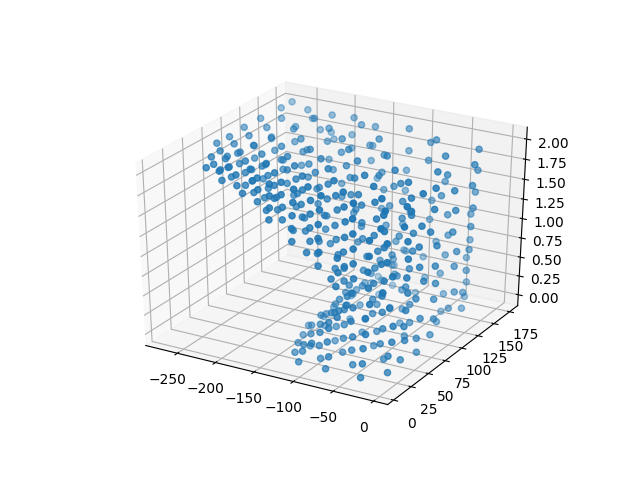

In [18]:
# # load a test or define your own problem
problem = osy_nd(n_obj = n_dim)

# get the optimal solution of the problem for the purpose of comparison
pf = problem.pareto_front()

# create the algorithm object
if n_dim <= 3:
    print("Running nsga2")
    method = nsga2(pop_size = npop, elimate_duplicates = True)
else:
    print("Running nsga3")
    method = nsga3(ref_dirs, pop_size = npop, elimate_duplicates = True)

# execute the optimization
res = minimize(problem,
               method,
               termination = ('n_gen', 500),
               pf = pf,
               disp = True)

fp = open("osy-{0:d}d.out".format(n_dim), "w")
F = res.F.tolist()
for f in F:
    fp.write("\t".join(["{0:.4f}".format(v) for v in f]) + "\n")
fp.close()

fp = open("osy-{0:d}d-x.out".format(n_dim), "w")
X = res.X.tolist()
for x in X:
    fp.write("\t".join(["{0:.4f}".format(v) for v in x]) + "\n")
fp.close()

fprcv = open("osy-{0:d}d-rcv.out".format(n_dim), "w")
fpccv = open("osy-{0:d}d-cv.out".format(n_dim), "w")
G = res.G.tolist()
for g in G:
    fprcv.write("\t".join(["{0:.4f}".format(v) for v in g]) + "\n")
    fpccv.write("{0:.4E}\n".format(math.fsum(g)))
fprcv.close()
fpccv.close()

print("\nObjective Space")
plotting.plot(res.F[:,0:3], no_fill = True)